In [1]:
###--------------------------------------------LOAD LIBRARIES

import numpy as np
import pandas as pd
import mygene
import omnipath as op
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
###--------------------------------------------DEFINE FUNCTIONS
def find_hits(target, db):                                                                      #Function for identifying genes that are targets or receptors (tgts) within a given database (db)
    hits = db['genesymbol_intercell_source'].isin(list(target.index))                           #Out of targets, which act as sources (aka: ligands)? 
    hits = hits.to_frame()
    hits['gene'] = list(db['genesymbol_intercell_source'])
    hits = hits[hits['genesymbol_intercell_source']==True]
    
    if (len(target.index.unique())>0):
        percSrc = len(hits['gene'].unique())/len(target.index.unique())*100
    else:
        percSrc = 0

    final_s = pd.merge(hits, db[['transmitter_intercell_source', 'receiver_intercell_source',
        'secreted_intercell_source',
        'plasma_membrane_transmembrane_intercell_source',
        'plasma_membrane_peripheral_intercell_source']], how="inner", left_index = True, right_index = True)
    final_s['source']=1
    final_s[['gene', 'source']]

    hits = db['genesymbol_intercell_target'].isin(list(target.index))
    hits = hits.to_frame()
    hits['gene'] = list(db['genesymbol_intercell_target'])
    hits = hits[hits['genesymbol_intercell_target']==True]
    
    if (len(target.index.unique())>0):
        percTgt = len(hits['gene'].unique())/len(target.index.unique())*100
    else:
        percTgt=0

    final_t = pd.merge(hits, db[['transmitter_intercell_target', 'receiver_intercell_target',
        'secreted_intercell_target',
        'plasma_membrane_transmembrane_intercell_target',
        'plasma_membrane_peripheral_intercell_target']], how="inner", left_index = True, right_index = True)
    final_t['target']=2
    final_t[['gene', 'target']]
    
    target['Empty'] = 0
    alltgt = target['Empty'].reset_index()
    alltgt.rename(columns = {'index':'gene'}, inplace = True)
    summary_LR = pd.merge(final_s[['gene', 'source','secreted_intercell_source',
       'plasma_membrane_transmembrane_intercell_source',
       'plasma_membrane_peripheral_intercell_source']], final_t[['gene', 'target', 'secreted_intercell_target',
       'plasma_membrane_transmembrane_intercell_target',
       'plasma_membrane_peripheral_intercell_target']], how="outer", on=['gene','gene']).fillna(0)
    summary_LR = pd.merge(summary_LR, alltgt, how="outer", left_on = ['gene'], right_on = ['genes']).fillna(0)
    summary_LR['source+target']=summary_LR['source']+summary_LR['target']
    summary_LR['source+target'].astype("category")
    summary_LR['source+target'].replace({
    0.0: 'None', 
    1.0: 'Source', 
    2.0: 'Target', 
    3.0: 'Source+Target'}, inplace = True)
    
    return(final_s, percSrc, final_t, percTgt, summary_LR.drop_duplicates(subset = ["gene"]))           #Return final sources, targets, corresponding percentegages and a 
                                                                                                        #summary ligand-receptor table including information of molecule type
                                                                                                        

def typeOfMolecule(summary_LR, disease):                                                                # Function for identifying the types of receptors (solluble, membrane expressed) flagged in find_hits function
    summary_LR[['secreted_intercell_source',
              'plasma_membrane_transmembrane_intercell_source',
              'plasma_membrane_peripheral_intercell_source',
              'secreted_intercell_target',
              'plasma_membrane_transmembrane_intercell_target',
              'plasma_membrane_peripheral_intercell_target']] = summary_LR[['secreted_intercell_source',
              'plasma_membrane_transmembrane_intercell_source',
              'plasma_membrane_peripheral_intercell_source',
              'secreted_intercell_target',
              'plasma_membrane_transmembrane_intercell_target',
              'plasma_membrane_peripheral_intercell_target']].astype(int)

    source_only = summary_LR[summary_LR['source+target']=='Source']
    source_tp = np.asarray([np.shape(source_only[source_only['secreted_intercell_source']==1])[0], 
              np.shape(source_only[source_only['plasma_membrane_transmembrane_intercell_source']==1])[0], 
              np.shape(source_only[source_only['plasma_membrane_peripheral_intercell_source']==1])[0]]).reshape(-1,1)

    target_only = summary_LR[summary_LR['source+target']=='Target']
    target_tp = np.asarray([
              np.shape(target_only[target_only['secreted_intercell_target']==1])[0], 
              np.shape(target_only[target_only['plasma_membrane_transmembrane_intercell_target']==1])[0], 
              np.shape(target_only[target_only['plasma_membrane_peripheral_intercell_target']==1])[0]]).reshape(-1,1)

    source_and_target = summary_LR[summary_LR['source+target']=='Source+Target']
    source_and_target_tp = np.asarray([np.shape(source_and_target[source_and_target['secreted_intercell_source']==1])[0], 
              np.shape(source_and_target[source_and_target['plasma_membrane_transmembrane_intercell_source']==1])[0], 
              np.shape(source_and_target[source_and_target['plasma_membrane_peripheral_intercell_source']==1])[0]]).reshape(-1,1)


    typemol = pd.DataFrame(np.concatenate((source_tp, target_tp, source_and_target_tp), axis = 1), 
                     index = ['source', 'target', 'source+target'], 
                     columns = ['secreted', 'transmembrane', 'peripheral'])

    typemol.transpose().plot(kind="bar", stacked=True, cmap = 'Dark2')
    plt.title("Types of Ligands and Receptors in %s" % disease)
    plt.savefig("../../../plots/gene-risk-LR-analysis/01-LR_occurrence_bootstrapped/Ls_Rs_in_%s.png" % disease, dpi = 300, bbox_inches='tight')
    plt.show()

    return(typemol)

def topocurring(targets, hits):                                                                 #Function for identifying top occuring genes in a set of groups (e.g.: diseases, databases)
    top10S = targets.loc[list(hits['gene'].unique())].sum(axis = 1).sort_values(ascending = False).to_frame(name = 'Occurances')
    top10S['Diseases'] = 'A'
    for n in range (0, len(list(top10S.index))):
        info = targets.loc[top10S.index[n]]
        info = info[info>0].to_frame()
        l = []
        for i in range (0,len(info.index)):
            l.append(info.index[i].split("_")[0])
        top10S['Diseases'][n] = ", ".join(np.unique(l))
    return top10S

def bootstrap_genes(n, iter, genelist, db):
    import random
    import seaborn as sns
    import matplotlib.pyplot as plt
    src = []
    tgt = []

    for i in range (0,iter):
        rand = random.sample(range(0,len(genelist)), n)                                         # Generate n random numbers for gene selection
        source, percSrc, targets, percTgt, sum = find_hits(pd.DataFrame(genelist.iloc[rand]).set_index('genes'), db)      # Select genes
        src.append(percSrc)
        tgt.append(percTgt)

    sns.histplot(data = src, bins = 20)
    plt.show()

    sns.histplot(data = tgt, bins = 20)
    plt.show
    return src, tgt

In [3]:
###--------------------------------------------LOAD DATA
df = pd.read_csv('../../../processed-data/gene-risk-LR-analysis/00-OpenTargets_SCZ_risk_genes/SCZ_risk_genes_01thr_hot1.csv', index_col = 0)

# import gtex expression data
gtex_link = 'https://storage.googleapis.com/gtex_analysis_v7/rna_seq_data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct.gz'
exp = pd.read_csv(gtex_link, sep='\t', index_col='gene_id', skiprows=2)
exp_cns = exp.loc[:, ['Brain - Anterior cingulate cortex (BA24)',
       'Brain - Caudate (basal ganglia)', 'Brain - Cerebellar Hemisphere',
       'Brain - Cerebellum', 'Brain - Cortex', 'Brain - Frontal Cortex (BA9)',
       'Brain - Hippocampus', 'Brain - Hypothalamus',
       'Brain - Nucleus accumbens (basal ganglia)',
       'Brain - Putamen (basal ganglia)', 'Brain - Spinal cord (cervical c-1)',
       'Brain - Substantia nigra']]
exp_cns = exp_cns.loc[(exp_cns > 0).any(axis=1)]

# convert gtex gene names from ENSEMBL to gene symbols
mg = mygene.MyGeneInfo()
ensembl_gtex = list(np.unique(pd.DataFrame(list(exp_cns.index.str.split('.')))[0]))
symbols_gtex = mg.querymany(ensembl_gtex, scopes='ensembl.gene', fields='symbol', species='human')
symbols_gtex = pd.DataFrame(symbols_gtex)['symbol']

# import omnipath db
db = op.interactions.import_intercell_network(transmitter_params = {"categories":"ligand"}, receiver_params = {"categories": "receptor"})

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-32767...done.
Finished.
4 input query terms found dup hits:
	[('ENSG00000229425

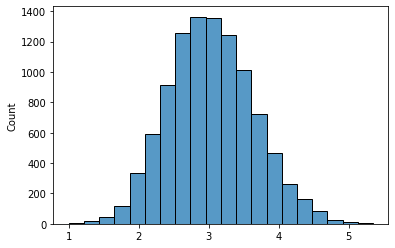

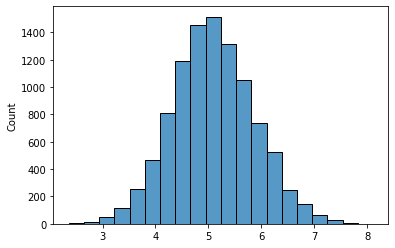

In [4]:
###--------------------------------------------BOOTSTRAPPING

src, tgt = bootstrap_genes(np.shape(df)[0], 10000, symbols_gtex.rename('genes'), db)

/tmp/slurm_48841202/ipykernel_55485/1093087256.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('../../../plots/gene-risk-LR-analysis/01-LR_occurrence_bootstrapped/bootstrapped_distribution_ligands_SCZ.pdf', dpi = 300, bbox = 'tight')


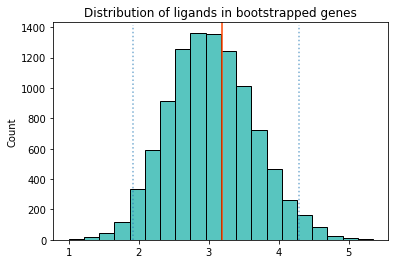

/tmp/slurm_48841202/ipykernel_55485/1093087256.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('../../../plots/gene-risk-LR-analysis/01-LR_occurrence_bootstrapped/bootstrapped_distribution_receptors_SCZ.pdf', dpi = 300, bbox = 'tight')


<function matplotlib.pyplot.show(close=None, block=None)>

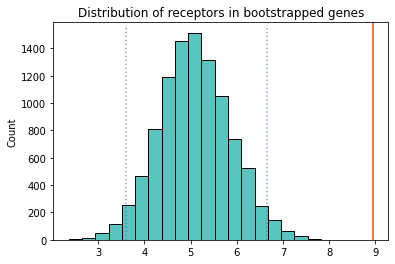

In [5]:
###--------------------------------------------LRs IN SCZ RISK GENES

#Calculate LR representation in SCZ risk genes
all_source, pctsrc, all_targets, pcttgt, summary_LR = find_hits(df,db)

g = sns.histplot(data = src, bins = 20, color = 'lightseagreen')
quant_5, quant_95 = np.quantile(src, 0.025), np.quantile(src, 0.975)
# [quantile, opacity, length]
quants = [[quant_5, 0.6, 0.99], [quant_95, 0.6, 0.99]]
for i in quants:
    g.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")
g.axvline(pctsrc, color = 'orangered')
plt.title('Distribution of ligands in bootstrapped genes')
plt.savefig('../../../plots/gene-risk-LR-analysis/01-LR_occurrence_bootstrapped/bootstrapped_distribution_ligands_SCZ.pdf', dpi = 300, bbox = 'tight')
plt.show()

g = sns.histplot(data = tgt, bins = 20, color = 'lightseagreen')
quant_5, quant_95 = np.quantile(tgt, 0.025), np.quantile(tgt, 0.975)
# [quantile, opacity, length]
quants = [[quant_5, 0.6, 0.99], [quant_95, 0.6, 0.99]]
for i in quants:
    g.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")
g.axvline(pcttgt, color = 'orangered')
plt.title('Distribution of receptors in bootstrapped genes')
plt.savefig('../../../plots/gene-risk-LR-analysis/01-LR_occurrence_bootstrapped/bootstrapped_distribution_receptors_SCZ.pdf', dpi = 300, bbox = 'tight')
plt.show